# Air temperature Karlskrona
## Import necessary libraries and read the csv file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math
from statistics import mean
df = pd.read_csv("SMHI_Data.csv")
df

,Datum,Tid (UTC),Lufttemperatur
0,2010-03-01,00:00:00,2.0
1,2010-03-01,01:00:00,NaN
2,2010-03-01,02:00:00,2.2
3,2010-03-01,03:00:00,1.7
4,2010-03-01,04:00:00,1.7
...,...,...,...
113976,2023-01-01,02:00:00,6.2
113977,2023-01-01,03:00:00,6.5
113978,2023-01-01,04:00:00,7.7
113979,2023-01-01,05:00:00,8.7


## Data cleaning process
The steps we will take in order to clean the data is firstly.

### Missing values
Approximately 6% of the air temperature values are missing which is quite a lot in our opinion but not so many that it is impossible to clean the data and draw meaningful conclusions

In [2]:
null_values = df["Lufttemperatur"].isnull().sum()
df_length = len(df)

print(f"Missing values: {null_values}, Total values: {df_length}, Percentage missing: {(null_values / df_length) * 100}%")

Missing values: 6713, Total values: 113981, Percentage missing: 5.889578087575999%


Replace NAN values with the average of the two not NAN neighbouring values with equal distance to the subject value.

In [3]:
df["Cleaned"] = 0.0

def find_value(df, index):
    j = 0
    backward = df.at[index - j, "Lufttemperatur"]
    forward = df.at[index + j, "Lufttemperatur"]
    while math.isnan(backward) or math.isnan(forward):
        backward = df.at[index - j, "Lufttemperatur"]
        forward = df.at[index + j, "Lufttemperatur"]
        j+=1
    c = (backward+forward)/2
    
    return c

        
for index, row in df.iterrows():
    if index == 113980:
        df.at[index, "Cleaned"] = df.at[index-1, "Lufttemperatur"]
    else:
        df.at[index, "Cleaned"] = find_value(df, index)

df

,Datum,Tid (UTC),Lufttemperatur,Cleaned
0,2010-03-01,00:00:00,2.0,2.0
1,2010-03-01,01:00:00,NaN,2.1
2,2010-03-01,02:00:00,2.2,2.2
3,2010-03-01,03:00:00,1.7,1.7
4,2010-03-01,04:00:00,1.7,1.7
...,...,...,...,...
113976,2023-01-01,02:00:00,6.2,6.2
113977,2023-01-01,03:00:00,6.5,6.5
113978,2023-01-01,04:00:00,7.7,7.7
113979,2023-01-01,05:00:00,8.7,8.7


### Outliers
Using the moving trimmed mean to replace outliers and get more reasonable data.

In [4]:
df["Trimmed"] = 0.0

def find_value(df, index):
    neighbors = [df.at[index, "Cleaned"]]
    for i in range(1, 3):
        try:
            backward = df.at[index - i, "Cleaned"]
            forward = df.at[index + i, "Cleaned"]
            neighbors.append(backward)
            neighbors.append(forward)
        except:
            pass
    return st.trim_mean(neighbors, 0.3)


for index, row in df.iterrows():
    df.at[index, "Trimmed"] = find_value(df, index)

df

,Datum,Tid (UTC),Lufttemperatur,Cleaned,Trimmed
0,2010-03-01,00:00:00,2.0,2.0,2.000000
1,2010-03-01,01:00:00,NaN,2.1,2.100000
2,2010-03-01,02:00:00,2.2,2.2,1.933333
3,2010-03-01,03:00:00,1.7,1.7,1.833333
4,2010-03-01,04:00:00,1.7,1.7,1.633333
...,...,...,...,...,...
113976,2023-01-01,02:00:00,6.2,6.2,6.466667
113977,2023-01-01,03:00:00,6.5,6.5,6.966667
113978,2023-01-01,04:00:00,7.7,7.7,7.633333
113979,2023-01-01,05:00:00,8.7,8.7,8.366667


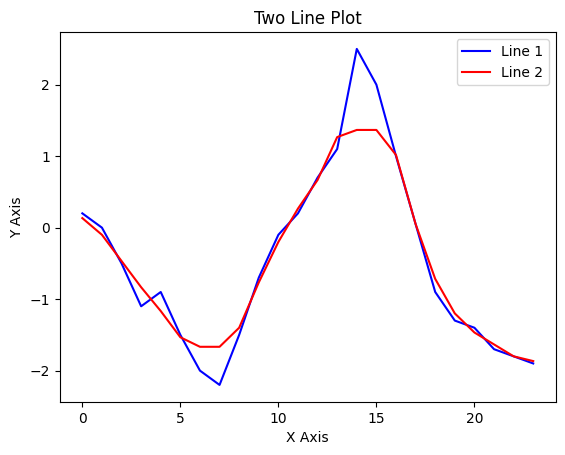

In [5]:
x = range(24)
y1 = df.Cleaned[24:48]
y2 = df.Trimmed[24:48]
plt.plot(x, y1, label='Line 1', color = "blue")
plt.plot(x, y2, label='Line 2', color="red")

# add a legend and labels
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Two Line Plot')


# display the plot
plt.show()

## Statistics

In [6]:
# Minimum and maximum
minimum = df[["Cleaned", "Trimmed"]].min()
maximum = df[["Cleaned", "Trimmed"]].max()

print(f'minimum: \n{minimum}, \n\nMaximum: \n{maximum}')

minimum: 
Cleaned   -19.2
Trimmed   -14.9
dtype: float64, 

Maximum: 
Cleaned    39.600000
Trimmed    36.833333
dtype: float64


In [7]:
# Mean
mean = df[["Cleaned", "Trimmed"]].mean()

print(f'\nMean: \n{mean}')


Mean: 
Cleaned    9.431147
Trimmed    9.421581
dtype: float64


In [8]:
# Quartiles
q1 = df[["Cleaned", "Trimmed"]].quantile(0.25)
q2 = df[["Cleaned", "Trimmed"]].quantile(0.5)
q3 = df[["Cleaned", "Trimmed"]].quantile(0.75)

print(f'\nQ1: \n{q1}, \n\nQ2: \n{q2}, \n\nQ3: \n{q3}')


Q1: 
Cleaned    4.1
Trimmed    4.1
Name: 0.25, dtype: float64, 

Q2: 
Cleaned    9.1
Trimmed    9.1
Name: 0.5, dtype: float64, 

Q3: 
Cleaned    15.200000
Trimmed    15.183333
Name: 0.75, dtype: float64


In [9]:
# Standard deviation
standard = df[["Cleaned", "Trimmed"]].std()

print(f'\nStandard deviation: \n{standard}')


Standard deviation: 
Cleaned    6.996330
Trimmed    6.948814
dtype: float64


In [10]:
#Confidence interval
sem = st.sem(df[["Cleaned", "Trimmed"]])
ci = st.t.interval(0.95, len(df[["Cleaned", "Trimmed"]]) - 1, loc=mean, scale=sem)
con_int = {"Cleaned": (ci[0][0], ci[1][0]), "Trimmed": (ci[0][1], ci[1][1])}

print(f'confidence intervals:\nCleaned: {con_int["Cleaned"]}, \n\nTrimmed: {con_int["Trimmed"]}')

confidence intervals:
Cleaned: (9.390530400257589, 9.471764192700888), 

Trimmed: (9.381239596848088, 9.461921690267017)


## Plotting the data

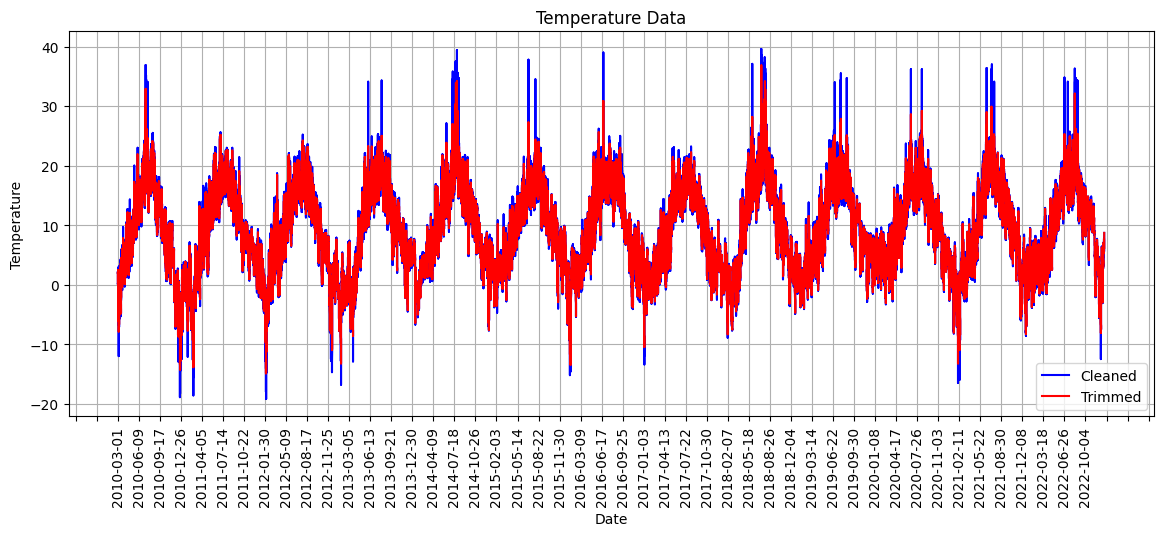

In [11]:
x = df.Datum
y1 = df.Cleaned
y2 = df.Trimmed

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(x, y1, label='Cleaned', color = "blue")
ax.plot(x, y2, label='Trimmed', color="red")

ax.xaxis.set_major_locator(plt.MaxNLocator(52))

# add a legend and labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Data')
ax.grid()
plt.legend()

plt.xticks(rotation=90)

# display the plot
plt.show()


## Coldest months

In [31]:
months_string = ["Januari", "February", "Mars", "April", "May", "June", "July", "August", "September", "Oktober", "November", "December"]
months = []
for year in range(2010, 2024):
    for month in range(1, 13):
        if month < 10:
            month_df = df[df.Datum < f"{year}-0{month}"]
            month_df = month_df[month_df.Datum > f"{year}-0{month-1}"]
        else:
            month_df = df[df.Datum < f"{year}-{month}"]
            if month == 10:
                month_df = month_df[month_df.Datum > f"{year}-0{month-1}"]
            else:
                month_df = month_df[month_df.Datum > f"{year}-0{month-1}"]
        if len(month_df) > 0:
            month_df.reset_index(inplace=True)
            months.append(month_df)

temp_dict = {}
for month in months:
    temp_dict[month["Datum"][0][0:7]] =  month["Trimmed"].mean()  

sorted_temp_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1]))

for i in range(10):
    print(f'{list(sorted_temp_dict.keys())[i][:4]}/{months_string[int(list(sorted_temp_dict.keys())[i][-1])-1]}: {list(sorted_temp_dict.values())[i]}')

2016/Januari: -0.9148714539007093
2013/Mars: -0.8217105263157893
2013/Januari: -0.6345285524568394
2011/Januari: -0.44054232804232807
2018/Mars: 0.005363475177305
2017/Januari: 0.7031808278867103
2021/Januari: 0.7869223867205025
2019/Januari: 1.0760773966578716
2014/Januari: 1.248947368421053
2012/Januari: 1.5675816993464056


## Finding the distrubution

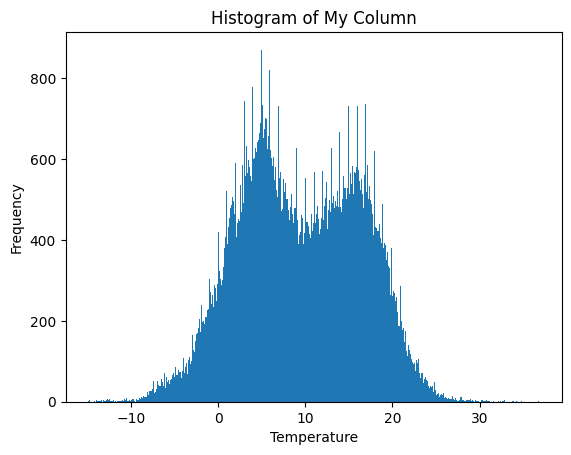

In [37]:
plt.hist(df['Trimmed'], bins=500)

# Add labels and a title to the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

# Display the plot
plt.show()